# 🧬 Differential Expression and Gene Set Enrichment Analysis

This notebook performs exploratory and hypothesis-driven analysis of a colorectal cancer (CRC) RNA-seq dataset using the following key steps:

---

## 🎯 Objectives

- Identify differentially expressed genes (DEGs) between defined clinical or biological groups using **PyDESeq2**.
- Explore biological processes and pathways enriched among DEGs using **Gene Set Enrichment Analysis (GSEA)** via **GSEApy**.
- Visualize expression patterns and enrichment results using advanced plotting techniques.

---

## 🔧 Tools and Methods

- **PyDESeq2**: A Python implementation of the DESeq2 statistical framework for RNA-seq count data. It models gene expression using a negative binomial distribution and accounts for biological variability.
- **GSEApy**: A Python wrapper for gene set enrichment analysis, supporting pre-ranked GSEA and many public gene set libraries (e.g., GO, KEGG, Reactome).
- **Seaborn / Matplotlib**: For customized heatmaps, volcano plots, and enrichment plots.

---

## 🧪 Workflow Overview

1. **Data Preparation**
   - Load normalized and filtered count data and metadata.
   - Match samples between expression and metadata tables.
   - Optional scaling for exploratory visualizations.

2. **Differential Expression Analysis**
   - Use PyDESeq2 to model differential expression between groups.
   - Extract and visualize top significant genes.

3. **Gene Set Enrichment**
   - Rank genes based on test statistic (e.g., Wald stat or log2 fold change).
   - Run GSEA on ranked gene list using GSEApy.
   - Plot top enriched biological pathways or GO terms.

---

## 📦 Input Data

- **Expression matrix**: Batch-corrected and normalized gene expression data.
- **Metadata**: Clinical/phenotypic data including sample type, age, sex, etc.

---

## 💡 Notes

- Only genes expressed in a sufficient number of samples are retained for analysis.
- Plots and results are annotated with clinical relevance where applicable.

---



## 🧪 Differential Expression Analysis (DE) with PyDESeq2

We apply the DESeq2 framework via PyDESeq2 to identify differentially expressed genes (DEGs) between predefined groups (e.g., tumor vs normal, different biopsy sites). PyDESeq2 fits a negative binomial model and adjusts for dispersion and covariates (e.g., age, sex) when provided. Significant genes are visualized via volcano plots and heatmaps.


In [ ]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import anndata
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import gseapy as gp

# importing the datasets
count_df = pd.read_csv('../data/raw_expression.csv', index_col=0)
metadata_df = pd.read_csv('../data/metadata.csv', index_col=0)
scaled_log_tmm = pd.read_csv('../data/scaled_log_expression.csv', index_col=0)

In [ ]:
# Create DESeqDataSet object
dds = DeseqDataSet(
    counts=count_df,  
    metadata=metadata_df,
    design_factors=["sample_type", 'age','gender']
)

# Run DESeq2 pipeline
dds.deseq2()



C:\Users\randf\AppData\Local\Temp\ipykernel_10340\3662641248.py:2: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(
Fitting size factors...


Using None as control genes, passed at DeseqDataSet initialization


... done in 2.69 seconds.

Fitting dispersions...
... done in 42.63 seconds.

Fitting dispersion trend curve...
... done in 0.97 seconds.

Fitting MAP dispersions...
... done in 38.50 seconds.

Fitting LFCs...
... done in 42.23 seconds.

Calculating cook's distance...
... done in 26.50 seconds.

Replacing 862 outlier genes.

Fitting dispersions...
... done in 2.70 seconds.

Fitting MAP dispersions...
... done in 3.01 seconds.

Fitting LFCs...
... done in 3.26 seconds.



In [3]:
# # Perform differential expression statistics (e.g., Tumor vs Normal)
ds = DeseqStats(dds, n_cpus=1,  contrast = ('sample_type','Healthy sample','Primary cancer'))
ds.summary()

# Results DataFrame
results = ds.results_df

# Rank genes by log2 fold change or Wald statistic
results = results.dropna(subset=["log2FoldChange", "pvalue"])

# Example ranking: by Wald statistic (stat column)
ranked_genes = results.sort_values(by="stat", ascending=False)

# Prepare ranked list for GSEA: gene names as index, stat as values
ranked_gene_list = pd.Series(data=ranked_genes["stat"].values, index=ranked_genes.index)

# Save or pass ranked_gene_list to gseapy
ranked_gene_list.to_csv("../results/ranked_genes.csv", header=False)


Running Wald tests...
... done in 14.09 seconds.



Log2 fold change & Wald test p-value: sample_type Healthy sample vs Primary cancer
              baseMean  log2FoldChange     lfcSE       stat         pvalue  \
A1BG         92.076198        2.684669  0.227644  11.793302   4.226411e-32   
A1BG-AS1     50.566340       -0.887158  0.088898  -9.979542   1.873302e-23   
A1CF        712.647817       -0.932422  0.096108  -9.701849   2.960845e-22   
A2M       10328.556775        0.195860  0.045158   4.337265   1.442669e-05   
A2M-AS1     156.259381       -0.063943  0.086165  -0.742104   4.580243e-01   
...                ...             ...       ...        ...            ...   
ZYG11A       38.395248       -3.482707  0.117857 -29.550251  6.518525e-192   
ZYG11B     1143.766323        0.684938  0.043031  15.917446   4.795598e-57   
ZYX        7511.496069       -2.243290  0.050228 -44.662056   0.000000e+00   
ZZEF1      3650.316712        0.314989  0.051562   6.108988   1.002651e-09   
ZZZ3       1220.040508       -0.260992  0.038030  -6.862713

C:\Users\randf\AppData\Roaming\Python\Python312\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


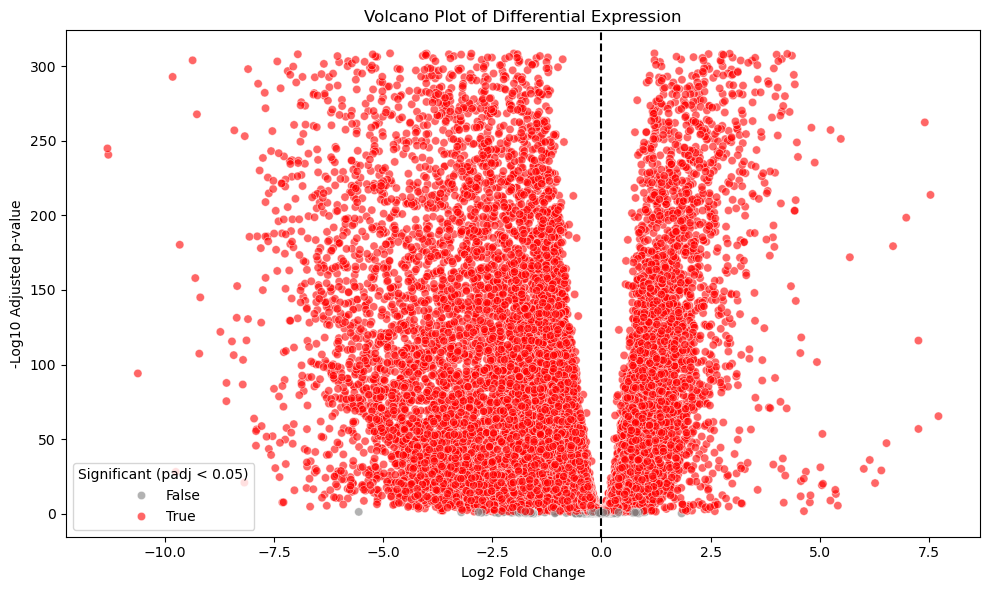

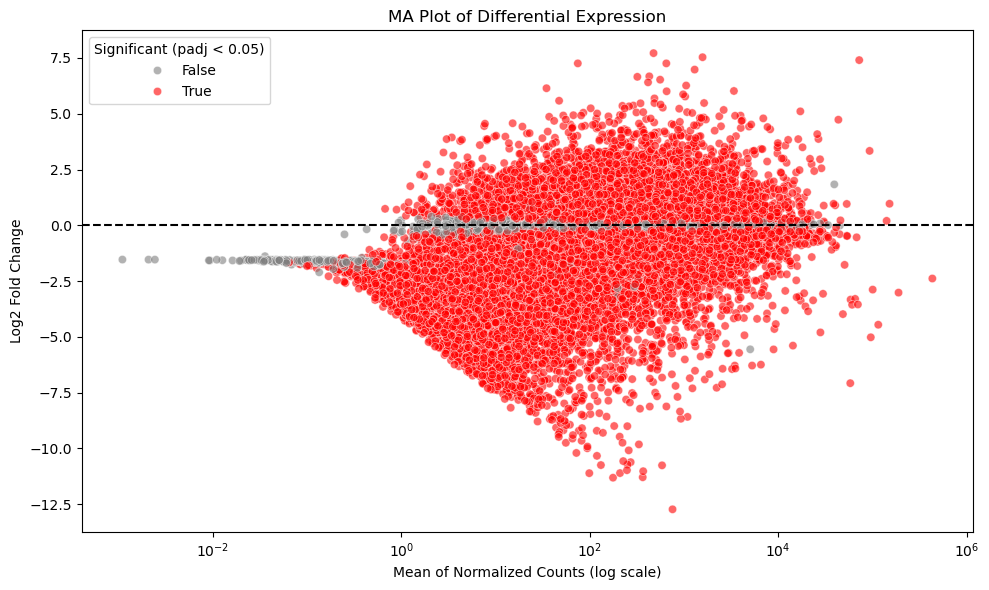

In [ ]:

# Filter out genes with missing values
results = results.dropna(subset=["log2FoldChange", "padj"])

# Volcano plot: log2FoldChange vs -log10(padj)
results['neg_log10_padj'] = -np.log10(results['padj'])

plt.figure(figsize=(10,6))
sns.scatterplot(data=results, x='log2FoldChange', y='neg_log10_padj',
                hue=results['padj'] < 0.05, palette={True: 'red', False: 'grey'}, alpha=0.6)
plt.axvline(x=0, color='black', linestyle='--')
plt.title('Volcano Plot of Differential Expression')
plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 Adjusted p-value')
plt.legend(title='Significant (padj < 0.05)')
plt.tight_layout()
plt.show()


# MA plot: Mean expression (baseMean) vs log2FoldChange
plt.figure(figsize=(10,6))
sns.scatterplot(data=results, x='baseMean', y='log2FoldChange',
                hue=results['padj'] < 0.05, palette={True: 'red', False: 'grey'}, alpha=0.6)
plt.xscale('log')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('MA Plot of Differential Expression')
plt.xlabel('Mean of Normalized Counts (log scale)')
plt.ylabel('Log2 Fold Change')
plt.legend(title='Significant (padj < 0.05)')
plt.tight_layout()
plt.show()




c:\Users\randf\.conda\envs\crc_env\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


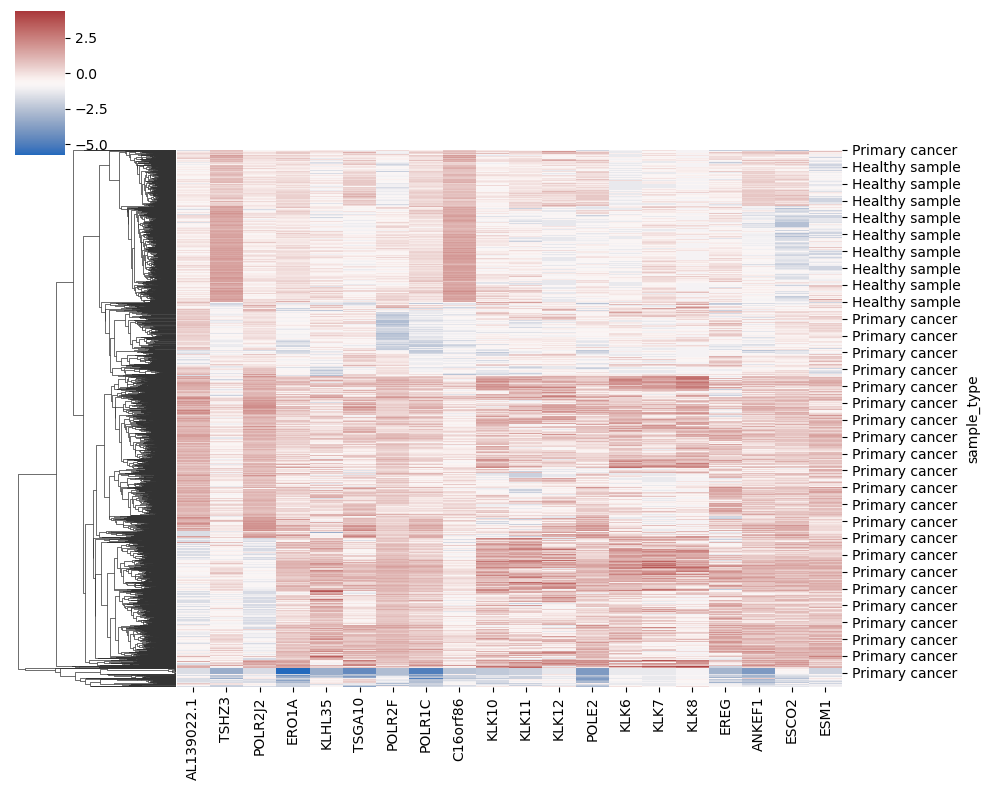

In [11]:
# Sort genes
top_genes = results.sort_values("padj").head(20).index

# Get heatmap data
heatmap_data = scaled_log_tmm[top_genes]  # samples x genes

# Replace sample names (index) with class labels
heatmap_data.index = metadata_df.loc[heatmap_data.index, 'sample_type']  # or 'condition', etc.

# Plot
sns.clustermap(heatmap_data, cmap="vlag", figsize=(10, 8), col_cluster=False)


## 🔬 Gene Set Enrichment Analysis (GSEA) with GSEApy

Using the ranked list of genes (e.g., by test statistic or log2 fold change), we perform pre-ranked Gene Set Enrichment Analysis (GSEA) with GSEApy. This helps identify enriched biological pathways or GO terms associated with the observed gene expression patterns. Top pathways are visualized with enrichment plots.


In [12]:


# Load ranked genes: a two-column CSV with gene names and ranking metric (e.g., stat)
ranked_genes = pd.read_csv("../results/ranked_genes.csv", index_col=0)

# Run pre-ranked GSEA using KEGG gene sets (you can change gene_sets to others, or provide your own GMT file)
pre_res = gp.prerank(
    rnk=ranked_genes,
    gene_sets='GO_Biological_Process_2021',
    permutation_num=100,  # Increase for more robust p-values, takes longer
    outdir='../results/gsea_results',  # Set to None if you do not want files saved
    no_plot=False,
    seed=42
)

# # Print top 5 enriched gene sets
print(pre_res.res2d.head())



      Name                                               Term        ES  \
0  prerank  regulation of release of sequestered calcium i...  0.767055   
1  prerank  regulation of cardiac muscle contraction by re...  0.781631   
2  prerank              muscle organ development (GO:0007517)  0.596745   
3  prerank       regulation of heart contraction (GO:0008016)  0.509168   
4  prerank  regulation of cardiac muscle contraction by ca...  0.674552   

        NES NOM p-val FDR q-val FWER p-val  Tag %  Gene %  \
0  2.716547       0.0       0.0        0.0  17/23  14.99%   
1  2.624317       0.0       0.0        0.0  13/17  13.25%   
2  2.595562       0.0       0.0        0.0  27/56  13.25%   
3  2.545802       0.0       0.0        0.0  40/91  12.53%   
4  2.531781       0.0       0.0        0.0  14/21  13.25%   

                                          Lead_genes  
0  CASQ2;GSTM2;HRC;CALM1;CASQ1;ATP1A2;CLIC2;CACNA...  
1  CASQ2;GSTM2;HRC;CALM1;ATP1A2;CLIC2;CACNA1C;ANK...  
2  SMTN;FHL1;SGCA

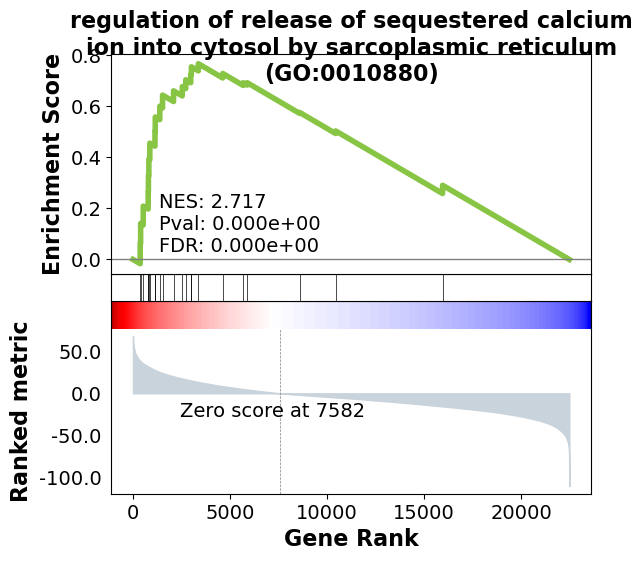

In [14]:
# Get top enriched term name (as string)
top_term = pre_res.res2d['Term'][0]

# Access full result for that term
gsea_result = pre_res.results[top_term]

# Plot using gseaplot() — requires hits and res
gp.plot.gseaplot(
    hits=gsea_result['hits'],
    RES=gsea_result['RES'],
    term=top_term,
    rank_metric=pre_res.ranking,
    nes=gsea_result['nes'],
    pval=gsea_result['pval'],
    fdr=gsea_result['fdr']
)

plt.show()
